In [1]:
import os 
import findspark 
findspark.init()

# for sql
from pyspark.sql import SparkSession 
from pyspark.sql.functions import col
from pyspark.sql.functions import sum,avg,max,count

# for time 
import time 
import datetime as dt


In [2]:
#root = '../../../2019-Oct.csv'
root = '../../data/only_purchases_1day.csv'
#root = '../../*.csv'
spark = SparkSession.builder.appName('eCommerce').getOrCreate()

24/01/30 10:27:03 WARN Utils: Your hostname, Nikolais-MacBook-Pro.local resolves to a loopback address: 127.0.0.1; using 100.119.9.7 instead (on interface en0)
24/01/30 10:27:03 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/01/30 10:27:04 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
24/01/30 10:27:04 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [3]:
ecommerce = spark.read\
    .option("inferSchema", "true")\
    .option("header", "true")\
    .csv(root)

In [4]:
ecommerce.createOrReplaceTempView('ecommerce_2019_oct')

In [5]:
ecommerce.printSchema()

root
 |-- event_time: timestamp (nullable = true)
 |-- event_type: string (nullable = true)
 |-- product_id: integer (nullable = true)
 |-- category_id: long (nullable = true)
 |-- category_code: string (nullable = true)
 |-- brand: string (nullable = true)
 |-- price: double (nullable = true)
 |-- user_id: integer (nullable = true)
 |-- user_session: string (nullable = true)



In [6]:
ecommerce.show(5)

+-------------------+----------+----------+-------------------+--------------------+-------+------+---------+--------------------+
|         event_time|event_type|product_id|        category_id|       category_code|  brand| price|  user_id|        user_session|
+-------------------+----------+----------+-------------------+--------------------+-------+------+---------+--------------------+
|2019-10-01 02:02:14|  purchase|   1004856|2053013555631882655|electronics.smart...|samsung|130.76|543272936|8187d148-3c41-46d...|
|2019-10-01 02:04:37|  purchase|   1002532|2053013555631882655|electronics.smart...|  apple|642.69|551377651|3c80f0d6-e9ec-418...|
|2019-10-01 02:06:02|  purchase|   5100816|2053013553375346967|                NULL| xiaomi| 29.51|514591159|0e5dfc4b-2a55-43e...|
|2019-10-01 02:07:07|  purchase|  13800054|2053013557418656265|furniture.bathroo...|santeri| 54.42|555332717|1dea3ee2-2ded-42e...|
|2019-10-01 02:09:26|  purchase|   4804055|2053013554658804075|electronics.audio...

### Try with smaller (day) to larger size (months) and show when the time takes to long

- Smaller days 

In [7]:
only_purchases = ecommerce.filter(col("event_type") == 'purchase')
only_purchases.show(5)

+-------------------+----------+----------+-------------------+--------------------+-------+------+---------+--------------------+
|         event_time|event_type|product_id|        category_id|       category_code|  brand| price|  user_id|        user_session|
+-------------------+----------+----------+-------------------+--------------------+-------+------+---------+--------------------+
|2019-10-01 02:02:14|  purchase|   1004856|2053013555631882655|electronics.smart...|samsung|130.76|543272936|8187d148-3c41-46d...|
|2019-10-01 02:04:37|  purchase|   1002532|2053013555631882655|electronics.smart...|  apple|642.69|551377651|3c80f0d6-e9ec-418...|
|2019-10-01 02:06:02|  purchase|   5100816|2053013553375346967|                NULL| xiaomi| 29.51|514591159|0e5dfc4b-2a55-43e...|
|2019-10-01 02:07:07|  purchase|  13800054|2053013557418656265|furniture.bathroo...|santeri| 54.42|555332717|1dea3ee2-2ded-42e...|
|2019-10-01 02:09:26|  purchase|   4804055|2053013554658804075|electronics.audio...

In [8]:
start_date = dt.datetime(2019,10,1)
end_date = dt.datetime(2019,10,2)

# filter data by date peirod 
specified_period = only_purchases.filter((col("event_time") >= start_date) & (col("event_time") < end_date))

# count number of rows
print(f'Number of rows: {specified_period.count()}')

start = time.time() 
# calculate average price for specified period
average_price_specified_period = specified_period.agg(avg("price")).collect()
print(f'average_price_specified_period: {average_price_specified_period}')
print(f'Average price for specified period ({start_date} to {end_date}): {average_price_specified_period[0][0]}')
print(f'Time taken: {time.time() - start} sec')

Number of rows: 19141
average_price_specified_period: [Row(avg(price)=324.980677603052)]
Average price for specified period (2019-10-01 00:00:00 to 2019-10-02 00:00:00): 324.980677603052
Time taken: 0.3356153964996338 sec


- larger size (whole month)

In [9]:
# count number of rows
oct30_date = dt.datetime(2019,10,31,23,59,59)
print(f'Number of rows: {only_purchases.count()}')
all_oct_purchases = only_purchases.filter(col("event_time") <= oct30_date)
print(f'Number of rows: {all_oct_purchases.count()}') 

Number of rows: 19307
Number of rows: 19307


In [10]:
from pyspark.sql import functions as F

# Use F.max for PySpark's max function
max_event_time = all_oct_purchases.agg(F.max("event_time")).collect()
print(f"Maximum event time: {max_event_time[0][0]}")

Maximum event time: 2019-10-02 01:58:48


In [11]:

start = time.time() 
# calculate average price for specified period
average_proce_all = all_oct_purchases.agg(avg("price")).collect()
print(f'average_proce_all: {average_proce_all}')
print(f'Average price for whole period: {average_proce_all[0][0]}')
print(f'Time taken: {time.time() - start} sec')

average_proce_all: [Row(avg(price)=325.0615843994414)]
Average price for whole period: 325.0615843994414
Time taken: 0.2498009204864502 sec


In [12]:
aggregated_data = only_purchases.groupBy("user_session") \
    .agg(
        F.max("event_time").alias("Date_order"),
        F.collect_set("user_id").alias("user_id"),  # Unique user_ids
        F.count("user_session").alias("Quantity"),
        F.sum("price").alias("money_spent")
    )
aggregated_data.show()

CodeCache: size=131072Kb used=28885Kb max_used=28885Kb free=102186Kb
 bounds [0x00000001079d8000, 0x0000000109648000, 0x000000010f9d8000]
 total_blobs=11164 nmethods=10206 adapters=868
 compilation: disabled (not enough contiguous free space left)
+--------------------+-------------------+-----------+--------+-----------+
|        user_session|         Date_order|    user_id|Quantity|money_spent|
+--------------------+-------------------+-----------+--------+-----------+
|0002c5ea-3509-4d0...|2019-10-01 08:10:46|[541539898]|       1|       9.76|
|000fdfe4-e1f0-4a9...|2019-10-01 15:37:06|[520206104]|       1|     259.98|
|001226df-03c7-41e...|2019-10-01 16:13:11|[516675926]|       1|    1619.09|
|001a0d5b-5b97-4a4...|2019-10-01 10:31:51|[541146978]|       1|     383.51|
|002ccd2c-50f7-412...|2019-10-01 07:49:27|[532770412]|       2|    1507.12|
|002d4fb1-81e7-40a...|2019-10-01 08:51:48|[551649560]|       1|     113.23|
|002eb2d4-76df-4da...|2019-10-01 19:37:03|[548751685]|       2|    1

Java HotSpot(TM) 64-Bit Server VM warning: CodeCache is full. Compiler has been disabled.
Java HotSpot(TM) 64-Bit Server VM warning: Try increasing the code cache size using -XX:ReservedCodeCacheSize=


# **RFM Analysis**
RFM is a method used for analyzing customer value. It is commonly used in database marketing and direct marketing and has received particular attention in retail and professional services industries.

RFM stands for the three dimensions:

* Recency – How recently did the customer purchase?
* Frequency – How often do they purchase?
* Monetary Value – How much do they spend?

source: [wikipedia](https://en.wikipedia.org/wiki/RFM_(market_research))

so we will calculate the 3 attributes Recency, Frequency, and Monetary

In [13]:
from pyspark.sql import functions as F
from pyspark.sql.types import DateType
import datetime as dt

# Assuming 'data' is your PySpark DataFrame and 'Date_order' is a string column
study_date = dt.datetime(2019, 12, 1)

# Convert 'Date_order' to date type if it's not already
data = aggregated_data.withColumn("Date_order", F.col("Date_order").cast(DateType()))

# Calculate the difference in days
data = data.withColumn("last_purchase", F.datediff(F.lit(study_date), "Date_order"))

# Show the first few rows of the DataFrame
data.show()


+--------------------+----------+-----------+--------+-----------+-------------+
|        user_session|Date_order|    user_id|Quantity|money_spent|last_purchase|
+--------------------+----------+-----------+--------+-----------+-------------+
|0002c5ea-3509-4d0...|2019-10-01|[541539898]|       1|       9.76|           61|
|000fdfe4-e1f0-4a9...|2019-10-01|[520206104]|       1|     259.98|           61|
|001226df-03c7-41e...|2019-10-01|[516675926]|       1|    1619.09|           61|
|001a0d5b-5b97-4a4...|2019-10-01|[541146978]|       1|     383.51|           61|
|002ccd2c-50f7-412...|2019-10-01|[532770412]|       2|    1507.12|           61|
|002d4fb1-81e7-40a...|2019-10-01|[551649560]|       1|     113.23|           61|
|002eb2d4-76df-4da...|2019-10-01|[548751685]|       2|    1012.56|           61|
|003c3709-b084-464...|2019-10-01|[514242794]|       3|     107.57|           61|
|0042dd5a-8850-475...|2019-10-01|[554093290]|       1|      130.7|           61|
|0043b973-66ee-4ed...|2019-1

In [14]:

RFM_result = data.groupBy("user_id") \
    .agg(
        F.min("last_purchase").alias("Recency"),
        F.count("user_id").alias("Frequency"),
        F.sum("money_spent").alias("Monetary")
    )

# Show the first few rows of the RFM DataFrame
RFM_result.show()


+-----------+-------+---------+------------------+
|    user_id|Recency|Frequency|          Monetary|
+-----------+-------+---------+------------------+
|[540805815]|     61|        2|            416.97|
|[554890606]|     61|        2|            180.68|
|[518550701]|     61|        2|           1951.12|
|[527993733]|     61|        1|            169.86|
|[519298781]|     61|        1|             177.1|
|[544161168]|     61|        1|            737.67|
|[512878155]|     61|        1|            254.26|
|[552269114]|     61|        2|            410.85|
|[555528707]|     61|        2|            313.26|
|[512817507]|     61|        1|           1080.18|
|[513263533]|     61|        2|            571.39|
|[521755518]|     61|        1|            161.93|
|[514537356]|     61|        2|            464.31|
|[546129282]|     61|        1|1108.4299999999998|
|[514399464]|     61|        2|           3397.72|
|[514264972]|     61|        2|           1729.77|
|[513902632]|     61|        1|

##### Recency – How recently did the customer purchase?
(befor days bought)


In [15]:
RFM_result.describe('Recency').show()

+-------+-------------------+
|summary|            Recency|
+-------+-------------------+
|  count|              14064|
|   mean|  60.99139647326508|
| stddev|0.09235860860653475|
|    min|                 60|
|    max|                 61|
+-------+-------------------+



##### Frequency – How often do they purchase?
(count times)


In [16]:
RFM_result.describe('Frequency').show()

+-------+------------------+
|summary|         Frequency|
+-------+------------------+
|  count|             14064|
|   mean|1.1553612059158134|
| stddev|0.5264487104076628|
|    min|                 1|
|    max|                10|
+-------+------------------+



##### Monetary Value – How much do they spend?
(per person totally amount)

In [17]:
RFM_result.describe('Monetary').show()

+-------+------------------+
|summary|          Monetary|
+-------+------------------+
|  count|             14064|
|   mean| 446.2431747724663|
| stddev|  743.075831746732|
|    min|              0.79|
|    max|30607.049999999996|
+-------+------------------+



# **RFM Segmentation**

RFM segmentation is a useful tool for identifying groups of clients who should be given extra attention. RFM segmentation enables marketers to target specific groups of customers with communications that are far more relevant to their unique behaviors, resulting in improved response rates, enhanced loyalty, and increased customer lifetime value. RFM segmentation is a method for segmenting data, just like other approaches.

The simplest way to create customers segments from RFM Model is to use Quartiles. We assign a score from 1 to 4 to Recency, Frequency and Monetary. Four is the best/highest value, and one is the lowest/worst value. A final RFM score is calculated simply by combining individual RFM score numbers.


### RFM Quartiles

In [18]:
# Definition der Quantil-Wahrscheinlichkeiten und des relativen Fehlers
quantile_probs = [0.25, 0.5, 0.75]
rel_error = 0.01  # Geringer relativer Fehler für eine genauere Approximation

# Berechnung der Quantile für Recency, Frequency und Monetary
recency_quantiles = RFM_result.stat.approxQuantile("Recency", quantile_probs, rel_error)
frequency_quantiles = RFM_result.stat.approxQuantile("Frequency", quantile_probs, rel_error)
monetary_quantiles = RFM_result.stat.approxQuantile("Monetary", quantile_probs, rel_error)

# Zusammenstellen der Quantilinformation in einem Dictionary
quartiles = {
    'Recency': dict(zip(quantile_probs, recency_quantiles)),
    'Frequency': dict(zip(quantile_probs, frequency_quantiles)),
    'Monetary': dict(zip(quantile_probs, monetary_quantiles))
}

# (Optional) Ausgabe der Quartile zum Überprüfen
for metric, quartile_values in quartiles.items():
    print(metric, quartile_values)

Recency {0.25: 61.0, 0.5: 61.0, 0.75: 61.0}
Frequency {0.25: 1.0, 0.5: 1.0, 0.75: 1.0}
Monetary {0.25: 102.71, 0.5: 223.69, 0.75: 506.29}


### Creation of RFM Segments

In [19]:
from pyspark.sql.functions import udf, col
from pyspark.sql.types import StringType, IntegerType

# UDF für Recency
def R(x, q1, q2, q3):
    if x <= q1:
        return 1
    elif x <= q2:
        return 2
    elif x <= q3:
        return 3
    else:
        return 4

# UDF für Frequency und Monetary
def FM(x, q1, q2, q3):
    if x <= q1:
        return 4
    elif x <= q2:
        return 3
    elif x <= q3:
        return 2
    else:
        return 1

# Extrahieren der Quartilswerte
recency_quartiles = [quartiles['Recency'][0.25], quartiles['Recency'][0.50], quartiles['Recency'][0.75]]
frequency_quartiles = [quartiles['Frequency'][0.25], quartiles['Frequency'][0.50], quartiles['Frequency'][0.75]]
monetary_quartiles = [quartiles['Monetary'][0.25], quartiles['Monetary'][0.50], quartiles['Monetary'][0.75]]

In [20]:
# Registrierung der UDFs
R_udf = udf(lambda x: R(x, *recency_quartiles), IntegerType())
FM_udf = udf(lambda x: FM(x, *frequency_quartiles), IntegerType())

# Anwendung der UDFs auf den Spark DataFrame
RFM_result = RFM_result.withColumn('R_Quartile', R_udf(col('Recency')))
RFM_result = RFM_result.withColumn('F_Quartile', FM_udf(col('Frequency')))
RFM_result = RFM_result.withColumn('M_Quartile', FM_udf(col('Monetary')))

# Erstellen der RFM_segmentation und RFM_score Spalten
RFM_result = RFM_result.withColumn('RFM_segmentation', 
                                   col('R_Quartile').cast(StringType()) + 
                                   col('F_Quartile').cast(StringType()) + 
                                   col('M_Quartile').cast(StringType()))
RFM_result = RFM_result.withColumn('RFM_score', 
                                   col('R_Quartile') + 
                                   col('F_Quartile') + 
                                   col('M_Quartile'))

# Anzeige der ersten paar Zeilen des DataFrame (Optional)
RFM_result.show()

+-----------+-------+---------+------------------+----------+----------+----------+----------------+---------+
|    user_id|Recency|Frequency|          Monetary|R_Quartile|F_Quartile|M_Quartile|RFM_segmentation|RFM_score|
+-----------+-------+---------+------------------+----------+----------+----------+----------------+---------+
|[540805815]|     61|        2|            416.97|         1|         1|         1|             3.0|        3|
|[554890606]|     61|        2|            180.68|         1|         1|         1|             3.0|        3|
|[518550701]|     61|        2|           1951.12|         1|         1|         1|             3.0|        3|
|[527993733]|     61|        1|            169.86|         1|         4|         1|             6.0|        6|
|[519298781]|     61|        1|             177.1|         1|         4|         1|             6.0|        6|
|[544161168]|     61|        1|            737.67|         1|         4|         1|             6.0|        6|
|

In [21]:
# UDF-Definition für RFM_label
def RFM_label(RFM_score):
    if RFM_score >= 10:
        return 'Lost'
    elif RFM_score >= 9:
        return 'Hibernating'
    elif RFM_score >= 8:
        return 'Can’t Lose Them'
    elif RFM_score >= 7:
        return 'About To Sleep'
    elif RFM_score >= 6:
        return 'Promising'
    elif RFM_score >= 5:
        return 'Potential Loyalist'
    elif RFM_score >= 4:
        return 'Loyal Customers'
    else:
        return 'Champions'

# Registrierung der UDF
RFM_label_udf = udf(RFM_label, StringType())

# Anwendung der UDF auf den Spark DataFrame
RFM_result = RFM_result.withColumn('RFM_label', RFM_label_udf('RFM_score'))

# Anzeigen der ersten Zeilen des DataFrame
RFM_result.show()

+-----------+-------+---------+------------------+----------+----------+----------+----------------+---------+---------+
|    user_id|Recency|Frequency|          Monetary|R_Quartile|F_Quartile|M_Quartile|RFM_segmentation|RFM_score|RFM_label|
+-----------+-------+---------+------------------+----------+----------+----------+----------------+---------+---------+
|[540805815]|     61|        2|            416.97|         1|         1|         1|             3.0|        3|Champions|
|[554890606]|     61|        2|            180.68|         1|         1|         1|             3.0|        3|Champions|
|[518550701]|     61|        2|           1951.12|         1|         1|         1|             3.0|        3|Champions|
|[527993733]|     61|        1|            169.86|         1|         4|         1|             6.0|        6|Promising|
|[519298781]|     61|        1|             177.1|         1|         4|         1|             6.0|        6|Promising|
|[544161168]|     61|        1| 

### How many customers do we have in each segment?

In [22]:
# Gruppieren nach 'RFM_label' und Berechnen der Durchschnittswerte sowie der Gruppengröße
RFM_desc = RFM_result.groupBy('RFM_label').agg(
    F.mean('Recency').alias('Average_Recency'),
    F.mean('Frequency').alias('Average_Frequency'),
    F.mean('Monetary').alias('Average_Monetary'),
    F.count('RFM_label').alias('Segment_Size')
)

# Runden der Durchschnittswerte auf eine Dezimalstelle
RFM_desc = RFM_desc.select(
    'RFM_label',
    F.round('Average_Recency', 1).alias('Average_Recency'),
    F.round('Average_Frequency', 1).alias('Average_Frequency'),
    F.round('Average_Monetary', 1).alias('Average_Monetary'),
    'Segment_Size'
)

# Anzeigen des aggregierten DataFrames
RFM_desc.show()

+-----------+---------------+-----------------+----------------+------------+
|  RFM_label|Average_Recency|Average_Frequency|Average_Monetary|Segment_Size|
+-----------+---------------+-----------------+----------------+------------+
|  Champions|           61.0|              2.4|          1108.0|        1577|
|  Promising|           61.0|              1.0|           362.7|       12485|
|Hibernating|           61.0|              1.0|             0.8|           2|
+-----------+---------------+-----------------+----------------+------------+



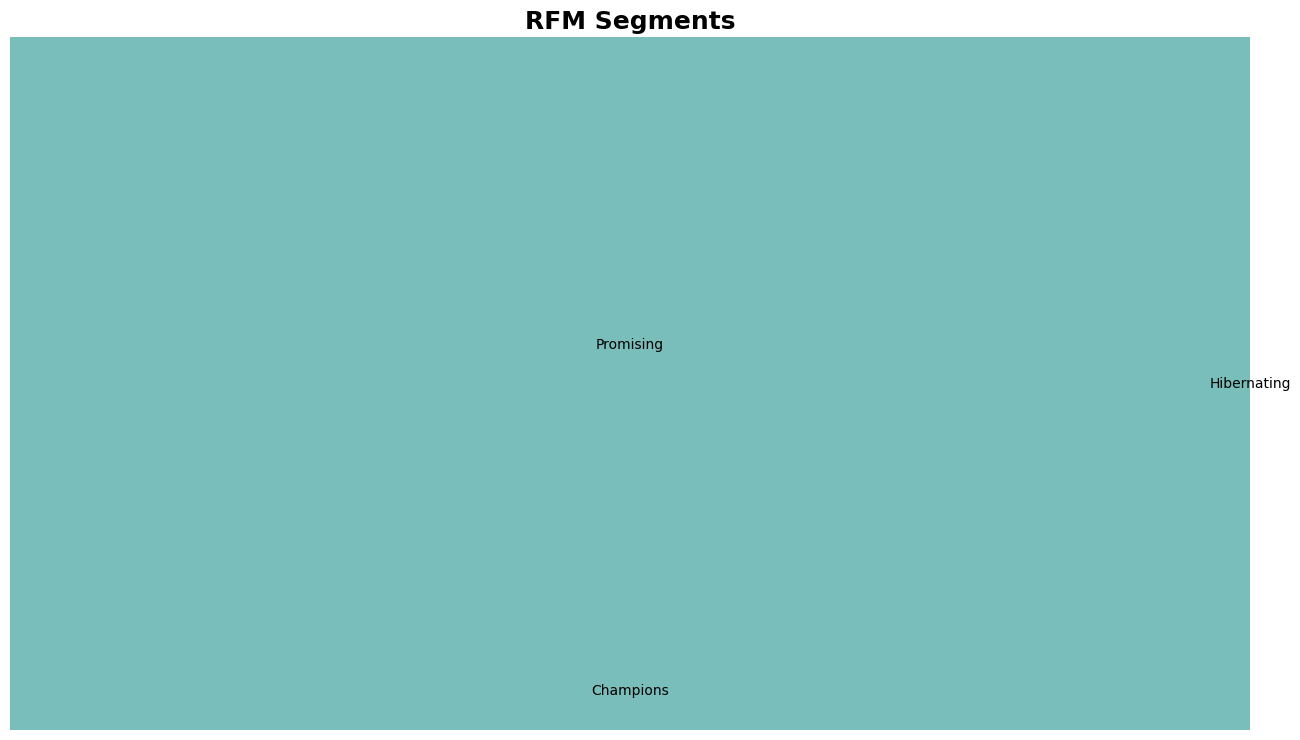

In [23]:
import matplotlib.pyplot as plt
import squarify


# Extract the necessary columns from the Spark DataFrame
sizes = RFM_desc.select("Segment_Size").rdd.flatMap(lambda x: x).collect()
labels = RFM_desc.select("RFM_label").rdd.flatMap(lambda x: x).collect()

# Create your plot and resize it
fig = plt.gcf()
ax = fig.add_subplot()
fig.set_size_inches(16, 9)

# Create squarify plot
squarify.plot(sizes=sizes, label=labels, alpha=.6)
plt.title("RFM Segments", fontsize=18, fontweight="bold")
plt.axis('off')
plt.show()





Now that we've identified our customer categories, we can decide how to approach or deal with each customer.

- **Champions:** Reward them. They can be early adopters of new products and are likely to promote your brand. They are most likely to send referrals.

- **Loyal Customer:** Upsell higher value products. Ask for reviews.

- **Potential Loyalist:** Offer membership/loyalty programs. Keep them engaged and provide personalized recommendations.

- **Promising:** Offer coupons. Bring them back to the platform and keep them engaged. Provide personalized recommendations.

- **About to Sleep:** Win them back via renewals or newer products. Don’t lose them to the competition. Talk to them if necessary. Spend time on the highest possible personalization.

- **Can't Lose Them:** Provide helpful resources on the site. Send personalized emails.

- **Hibernating:** Make subject lines of emails very personalized. Revive their interest with a specific discount on a specific product.

- **Lost:** Revive interest with a reach-out campaign. Ignore otherwise.


reference : [bloomreach](https://documentation.bloomreach.com/engagement/docs/rfm-segmentation)
